In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
dataset = '../datasets/jena_climate/jena_climate_2009_2016.csv'

In [4]:
df = pd.read_csv(dataset, index_col=0)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df_normalized = (df - df.mean())/df.std()
df_normalized = df_normalized.reset_index(drop=True)
df_normalized.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.874229,-2.074010,-2.127439,-2.058613,1.049500,-1.323973,-1.535254,-0.780586,-1.536971,-1.539461,2.293603,-0.010271,-0.018931,-0.258921
1,0.880211,-2.120310,-2.173297,-2.115071,1.055569,-1.336894,-1.556764,-0.782628,-1.555795,-1.560710,2.344885,-0.015008,-0.022553,-0.445812
2,0.875425,-2.132182,-2.185056,-2.119528,1.085916,-1.339478,-1.559154,-0.784670,-1.559560,-1.563071,2.355891,-0.023106,-0.035159,-0.036268
3,0.873032,-2.108438,-2.160363,-2.083871,1.104124,-1.333018,-1.544814,-0.786712,-1.544501,-1.548905,2.329625,-0.020814,-0.037042,0.268295
4,0.873032,-2.103690,-2.156835,-2.079413,1.098055,-1.331726,-1.542424,-0.786712,-1.544501,-1.546544,2.324872,-0.021120,-0.035159,0.456339


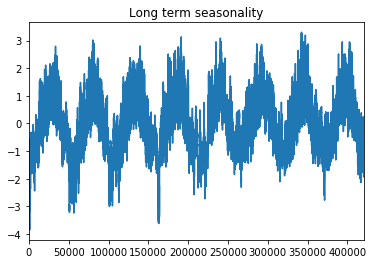

In [6]:
df_normalized['T (degC)'].plot()
plt.title('Long term seasonality')
plt.show()

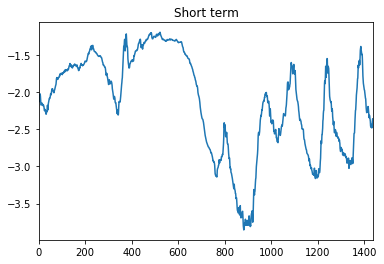

In [7]:
df_normalized['T (degC)'][:1440].plot()
plt.title('Short term')
plt.show()

In [8]:
def generator(data, lookback, delay, min_index=0, max_index=None,
              shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = data.shape[0] - delay - 1
    stop = min_index + lookback 
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, batch_size)
            
        else:
            batch_stop = min(stop + batch_size, max_index)
            rows = np.arange(stop, batch_stop, 1)
            stop += len(rows)
            
            if  stop + batch_size >= max_index:
                stop = min_index + lookback #Cycle generator back to beginning
            
        samples = np.zeros( (len(rows), lookback//step, data.shape[-1]) )
        targets = np.zeros( (len(rows),) )
        
        for idx, row in enumerate(rows):
            indices = range(row-lookback, row, step)
            samples[idx] = data.iloc[indices].values
            targets[idx] = data.iloc[row + delay]['T (degC)']
        yield samples, targets  

In [9]:
lookback = 1440
delay = 144
batch_size = 128
step = 6

In [10]:
train_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, batch_size=batch_size, step=step)
val_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=False, batch_size=batch_size, step=step)
test_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=False, batch_size=batch_size, step=step)

val_steps = 300000 - 200001 - lookback
test_steps = df_normalized.shape[0] - 300001 - lookback